# Rift delineation using Random Forest

This notebook employs the Random Forest algorithm, an ensemble machine learning method, to classify each point along an ICESat-2 track based on whether or not that point lies within a rift. We start by selecting the number of decision trees to include in our forest:

In [1]:
trees = 100 #choose the number of decision trees

We then import all necessary packages and modules: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

and set paths as necessary.

In [3]:
root_path = '/data/fast1/rift-id/'
outputs_path = root_path + 'outputs' #where the training data are stored

## Step 1: Load all relevant datasets

We'll load elevation profiles for each track (rifted and non-rifted) and normalize each elevation profile by its maximal value. Meanwhile, we'll also load label arrays which label each point along each track as either "within a rift" (1) or "not within a rift" (0). These data will be used to together to train the rift delineation model.

In [4]:
training_data_1 = pd.read_pickle(outputs_path + '/dml_all_bin_lr.pkl') #load the training data with rifted ice
training_data_0 = pd.read_pickle(outputs_path + '/dml_all_bin_lr_nonrift.pkl') #load the non-rift training data

#elevation profiles are used for training the first model
elevation_profiles = training_data_1['h_subset'] #surface elevations along each track
elevation_profiles_1 = np.array([profile/np.max(profile) for profile in elevation_profiles]) #where '1' indicates rifted ice
elevation_profiles = training_data_0['h_subset']
elevation_profiles_0 = np.array([profile/np.max(profile) for profile in elevation_profiles]) #and '0' indicates non-rifted ice

#point labels are used for training the second model
labels = training_data_1['bin_subset']
labels_1 = np.array([label for label in labels]) #to ensure labels_1 has the same shape as elevation_profiles_1
labels_0 = np.zeros(np.shape(elevation_profiles_0)) #and noting that all entries are '0' in the non-rifted tracks

## Step 2: Train the model

In [5]:
elevation_profiles = np.concatenate([elevation_profiles_1, elevation_profiles_0]) #concatenate all surface elevation profiles
labels = np.concatenate([labels_1, labels_0])

training_data = {
    'features': elevation_profiles,
    'labels': labels
}

X_train, X_test, Y_train, Y_test = train_test_split(training_data['features'], training_data['labels'], 
                                                    test_size = 0.2, random_state=0)
track_model = RandomForestClassifier(n_estimators = trees)
track_model.fit(X_train, Y_train)
score = track_model.score(X_test,Y_test)
print(f'model score: {100*score : 0.2f}%')

model score:  91.89%


## Step 3: Test the model

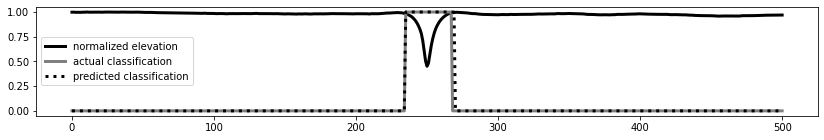

In [6]:
index = 2 #choose a track to feed into the model
input_track = np.array([elevation_profiles_1[index]])
actual_labels = np.array([labels_1[index]]) #the actual labels along that track
predicted_labels = track_model.predict(input_track) #the predicted labels along that track

plt.figure(figsize = (14, 2))
plt.plot(input_track[0], color = '0', linewidth = 3, label = 'normalized elevation')
plt.plot(actual_labels[0], color = '0.5', linewidth = 3, label = 'actual classification')
plt.plot(predicted_labels[0], color = '0', linewidth = 3, linestyle = 'dotted', label = 'predicted classification')
# plt.plot(actual_labels[0] - predicted_labels[0], color = 'blue', label = 'misfit')
plt.legend(loc = 'center left')